In [1]:

import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
import re
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Flatten
from keras.layers import Convolution1D as Conv1D, MaxPooling1D


C:\Users\lxg388\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
# loads the dataset and extracts the two columns we need:
def ingest():
    data = pd.read_csv('./Sentiment Analysis Dataset.csv',
                       #encoding='ISO-8859-1'
                       encoding='utf-8'
                       )
    data.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map(int)
    data = data[data['SentimentText'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    data.drop(data.columns[[2,3,4]], axis=1, inplace=True)
    print ('dataset loaded with shape', data.shape)    
    return data

data = ingest()


C:\Users\lxg388\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


dataset loaded with shape (1048575, 2)


In [3]:
# clean data: remove punctuations, user mentions, hashtages and urls
def clean_tweet(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Utility function to clean tweet text by removing links, special characters using simple regex statements.
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)", " ", tweet).split())

#Tokenization    
data['tokens'] = data['SentimentText'].apply(lambda x: tokenizer.tokenize(clean_tweet(x)))
data.head(5)

,Sentiment,SentimentText,tokens
0,0,is so sad for my APL frie...,"[is, so, sad, for, my, apl, friend]"
1,0,I missed the New Moon trail...,"[i, missed, the, new, moon, trailer]"
2,1,omg its already 7:30 :O,"[omg, its, already, o]"
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,"[omgaga, im, sooo, im, gunna, cry, i, ve, been..."
4,0,i think mi bf is cheating on me!!! ...,"[i, think, mi, bf, is, cheating, on, me, t, t]"


In [4]:
# remove stop words

stopset = set(stopwords.words('english'))
data['tokens1'] = [list(filter(lambda t: t not in stopset, w)) for w in data['tokens']]
#data['tokens2'] = [list(filter(lambda t: len(t)>3, w)) for w in data['tokens']]
data.head(5)

,Sentiment,SentimentText,tokens,tokens1
0,0,is so sad for my APL frie...,"[is, so, sad, for, my, apl, friend]","[sad, apl, friend]"
1,0,I missed the New Moon trail...,"[i, missed, the, new, moon, trailer]","[missed, new, moon, trailer]"
2,1,omg its already 7:30 :O,"[omg, its, already, o]","[omg, already]"
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,"[omgaga, im, sooo, im, gunna, cry, i, ve, been...","[omgaga, im, sooo, im, gunna, cry, dentist, si..."
4,0,i think mi bf is cheating on me!!! ...,"[i, think, mi, bf, is, cheating, on, me, t, t]","[think, mi, bf, cheating]"


In [5]:
x_train, x_test, y_train, y_test,text_train,text_test = train_test_split(np.array(data['tokens']),
                                                          np.array(data['Sentiment']),
                                                          np.array(data['SentimentText']), test_size=0.2)

In [6]:
#turn tokens into LabeledSentence objects 
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

838860it [00:05, 144880.83it/s]
209715it [00:00, 255750.02it/s]


In [7]:
x_train[0]

LabeledSentence(words=['alrite', 'after', 'i', 'finish', 'designing', 'the', 'website', 'the', 'problem', 'is', 'i', 'don', 't', 'have', 'bigger', 'papers', 'with', 'those', 'colors', 'u', 'mentioned'], tags=['TRAIN_0'])

In [8]:
# build the word2vec model 
n_dim=200
tweet_w2v = Word2Vec(size=n_dim, min_count=6)
tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])
tweet_w2v.train([x.words for x in tqdm(x_train)],total_examples = tweet_w2v.corpus_count,epochs=tweet_w2v.iter)

100%|██████████| 838860/838860 [00:00<00:00, 1522432.27it/s]


41107882

In [9]:
# returns the top similar words
tweet_w2v.most_similar('awesome')

[('amazing', 0.8696708083152771),
 ('awsome', 0.7961864471435547),
 ('incredible', 0.7797060012817383),
 ('fantastic', 0.6814783215522766),
 ('hilarious', 0.6743214130401611),
 ('great', 0.6557537913322449),
 ('fab', 0.6456575393676758),
 ('brilliant', 0.6384691596031189),
 ('rad', 0.6323255300521851),
 ('amazin', 0.6127955913543701)]

In [10]:
tweet_w2v.most_similar('loan')

[('insurance', 0.5864913463592529),
 ('fund', 0.5842595100402832),
 ('transfer', 0.5840397477149963),
 ('visa', 0.5829030275344849),
 ('license', 0.577026903629303),
 ('discount', 0.5766684412956238),
 ('debit', 0.5749881267547607),
 ('replacement', 0.5733175277709961),
 ('card', 0.5704193115234375),
 ('repair', 0.5694400072097778)]

In [97]:
#build a knowledge graph visualizing these word 

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [tweet_w2v[w] for w in list(tweet_w2v.wv.vocab.keys())[:5000]]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:5000]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)



Loading BokehJS ...

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.148596
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.955717
[t-SNE] Error after 275 iterations: 0.955717


In [11]:
#building tf-idf matrix 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=6)
matrix = vectorizer.fit_transform([x.words for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
len(tfidf)

31909

In [12]:
# given a list of tweet tokens, creates an averaged tweet vector.
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [13]:
#convert x_train and and x_test into list of vectors, 
#also scale each column to have zero mean and unit standard deviation.
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)


838860it [01:39, 8468.03it/s]
209715it [00:24, 8416.88it/s]


In [124]:
#svm classifier

model_SVC=SVC(kernel='rbf',max_iter=10000,tol=0.001,verbose=True)
model_SVC.fit(train_vecs_w2v[:100000], y_train[:100000])

[LibSVM]

C:\Users\lxg388\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [125]:
model_SVC.score(test_vecs_w2v, y_test)

KeyboardInterrupt: 

In [14]:
# neural network classifier 

batch_size=32

modelNN = Sequential()
modelNN.add(Dense(256, activation='relu', input_dim=200))
modelNN.add(Dense(128, activation='relu', input_dim=256))
modelNN.add(Dense(64, activation='relu', input_dim=128))
modelNN.add(Dense(1, activation='sigmoid'))
modelNN.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

modelNN.fit(train_vecs_w2v, y_train, epochs=6, batch_size=batch_size, verbose=2)


Epoch 1/6
66s - loss: 0.4824 - acc: 0.7747
Epoch 2/6
66s - loss: 0.4741 - acc: 0.7843
Epoch 3/6
76s - loss: 0.4740 - acc: 0.7878
Epoch 4/6
68s - loss: 0.4778 - acc: 0.7895
Epoch 5/6
69s - loss: 0.4748 - acc: 0.7912
Epoch 6/6
68s - loss: 0.4750 - acc: 0.7926


In [ ]:
# loss and accuracy
score_nn = modelNN.evaluate(test_vecs_w2v, y_test, batch_size=32, verbose=2)
score_nn

In [20]:
y_score = modelNN.predict(test_vecs_w2v)
y_pred=[1 if x >= 0.5 else 0 for x in y_score]

In [16]:
# confusion matrix
conf = sklearn.metrics.confusion_matrix(y_test, y_pred)
#plt.imshow(conf, cmap='binary', interpolation='None')
#plt.show()
conf

array([[76863, 22024],
       [22626, 88202]])

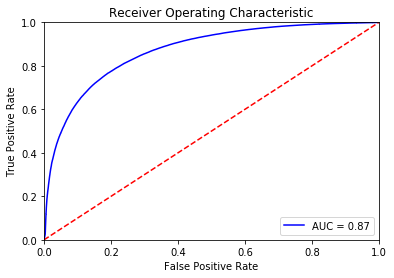

In [21]:
# ROC curve
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, y_score)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [60]:
# convolutional neural network classifier 
model_cnn = Sequential()
trainX_cnn=np.reshape(train_vecs_w2v,(train_vecs_w2v.shape[0],train_vecs_w2v.shape[1],1))
model_cnn.add(Conv1D(128, 10, 
                 activation='relu',
                 input_shape=(trainX_cnn.shape[1],trainX_cnn.shape[2])))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_cnn.fit(trainX_cnn, y_train, epochs=6, batch_size=batch_size, verbose=2)

Epoch 1/6
279s - loss: 0.4896 - acc: 0.7622
Epoch 2/6
289s - loss: 0.4750 - acc: 0.7711
Epoch 3/6
277s - loss: 0.4709 - acc: 0.7743
Epoch 4/6
280s - loss: 0.4690 - acc: 0.7757
Epoch 5/6
298s - loss: 0.4680 - acc: 0.7764
Epoch 6/6
286s - loss: 0.4671 - acc: 0.7770


In [64]:
score_cnn = model_cnn.evaluate(np.reshape(test_vecs_w2v,(test_vecs_w2v.shape[0],test_vecs_w2v.shape[1],1)),
                                          y_test, batch_size=32, verbose=2)
score_cnn

[0.47472499312227967, 0.77305390649072303]

In [71]:
# reshape X to be [samples, time steps, features]
from keras.layers import LST
seq_length = 3
trainX_lstm = []
trainY_lstm = []
for i in range(0, len(train_vecs_w2v) - seq_length, 1):
    seq_in = train_vecs_w2v[i:i + seq_length,]
    seq_out = y_train[i + seq_length,]
    trainX_lstm.append(seq_in)
    trainY_lstm.append(seq_out)
trainX_lstm=np.reshape(trainX_lstm,(train_vecs_w2v.shape[0],seq_length,train_vecs_w2v.shape[1]))
trainY_lstm=np.reshape(trainY_lstm,(y_train.shape[0],seq_length,1))


batch_size=32

model = Sequential()
#model.add(Dense(256, activation='relu', input_dim=200))
model.add(LSTM(64, dropout=0.2,recurrent_dropout=0.2,
               input_shape=(train_vecs_w2v_lstm.shape[1],train_vecs_w2v_lstm.shape[2]),
         return_sequences=False))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(128, activation='relu', input_dim=256))
#model.add(Dense(64, activation='relu', input_dim=128))
#model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_vecs_w2v_lstm, y_train_lstm, epochs=6, batch_size=batch_size, verbose=2)

ValueError: cannot reshape array of size 503314200 into shape (838860,3,200)

In [ ]:
#unsupervise model
from textblob import TextBlob

def get_tweet_sentiment(tweet):

    #Utility function to classify sentiment of passed tweet using textblob's sentiment method
  
    # create TextBlob object of passed tweet text
    analysis = TextBlob(tweet)
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 0

data['Sentiment_tb'] = [get_tweet_sentiment(tweet) for tweet in data['SentimentText']]

sum[data[x,'Sentiment_tb']==data[x,'Sentiment'] for x in range(len(data))]

In [34]:
RealTime = pd.read_csv('./CO0801.csv',index_col=False,
                       #encoding='ISO-8859-1'
                       encoding='utf-8'
                       )

,id,tweetCreated,userName,tweetText,cleanText,sentiment_tb,sentiment_af,retweet_count,favorite_count,userLocation,tweetDate,tweetDay,pFra,nFra
0,8.925530e+17,8/2/2017 1:08,Chris,2008 Capital one bowl Michigan vs Florida . Ll...,Capital one bowl Michigan vs Florida Lloyd Car...,-0.20,0,0,0,"Florida, USA",8/2/2017,2,0.333333,0.083333
1,8.925500e+17,8/2/2017 0:58,Jason McKown,So the Capital One &amp; Done Center..? https:...,So the Capital One amp Done Center,-0.10,0,0,0,NaN,8/2/2017,2,0.333333,0.083333
2,8.925490e+17,8/2/2017 0:54,DCist,The Capitals may soon be playing at a venue na...,The Capitals may soon be playing at a venue na...,0.00,0,5,6,"Washington, D.C.",8/2/2017,2,0.333333,0.083333
3,8.925490e+17,8/2/2017 0:53,"Rod ""TSA"" Williams","""Capital One Arena/Center"" just doesn't roll o...",Capital One Arena Center just doesn t roll off...,-0.10,0,0,0,A Title-less Cesspool,8/2/2017,2,0.333333,0.083333
4,8.925480e+17,8/2/2017 0:50,KawanaSCharles,I had 2 give up all my Capital One Mastercard ...,I had give up all my Capital One Mastercard ca...,0.35,0,0,0,"Orleans, Ontario",8/2/2017,2,0.333333,0.083333


In [35]:
RealTime['tokens'] = RealTime['cleanText'].map(lambda x: tokenizer.tokenize(clean_tweet(x)))
RealTime['score_nn'] = [modelNN.predict(buildWordVector(RealTime.loc[z,'tokens'], n_dim))[0][0] 
                                     for z in range(len(RealTime))]
RealTime['sentiment_nn']= ['positive' if x > 0.5 else 'negative' for x in RealTime['score_nn']]
RealTime.head(5)

,id,tweetCreated,userName,tweetText,cleanText,sentiment_tb,sentiment_af,retweet_count,favorite_count,userLocation,tweetDate,tweetDay,pFra,nFra,tokens,score_nn,sentiment_nn
0,8.925530e+17,8/2/2017 1:08,Chris,2008 Capital one bowl Michigan vs Florida . Ll...,Capital one bowl Michigan vs Florida Lloyd Car...,-0.20,0,0,0,"Florida, USA",8/2/2017,2,0.333333,0.083333,"[capital, one, bowl, michigan, vs, florida, ll...",0.467958,negative
1,8.925500e+17,8/2/2017 0:58,Jason McKown,So the Capital One &amp; Done Center..? https:...,So the Capital One amp Done Center,-0.10,0,0,0,NaN,8/2/2017,2,0.333333,0.083333,"[so, the, capital, one, amp, done, center]",0.467958,negative
2,8.925490e+17,8/2/2017 0:54,DCist,The Capitals may soon be playing at a venue na...,The Capitals may soon be playing at a venue na...,0.00,0,5,6,"Washington, D.C.",8/2/2017,2,0.333333,0.083333,"[the, capitals, may, soon, be, playing, at, a,...",0.474175,negative
3,8.925490e+17,8/2/2017 0:53,"Rod ""TSA"" Williams","""Capital One Arena/Center"" just doesn't roll o...",Capital One Arena Center just doesn t roll off...,-0.10,0,0,0,A Title-less Cesspool,8/2/2017,2,0.333333,0.083333,"[capital, one, arena, center, just, doesn, t, ...",0.159883,negative
4,8.925480e+17,8/2/2017 0:50,KawanaSCharles,I had 2 give up all my Capital One Mastercard ...,I had give up all my Capital One Mastercard ca...,0.35,0,0,0,"Orleans, Ontario",8/2/2017,2,0.333333,0.083333,"[i, had, give, up, all, my, capital, one, mast...",0.047020,negative


In [36]:
#RealTime.to_csv("Result.csv",encoding='utf-8')

In [45]:
counts = RealTime.groupby(['tweetDate','sentiment_nn'])['id'].count()

count     16.000000
mean     122.750000
std       64.316405
min        3.000000
25%       93.500000
50%      137.000000
75%      168.750000
max      230.000000
Name: id, dtype: float64

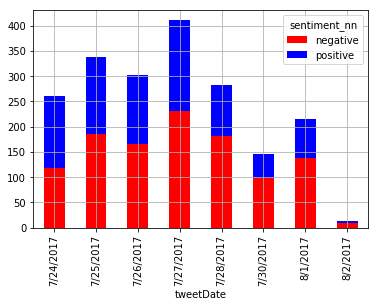

In [49]:
counts.unstack().plot(kind='bar',stacked=True,  color=['red','blue'], grid=False)
plt.show()